In [4]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf

DEAM_ROOT = os.path.abspath("DEAM")  # DEAM folder next to notebook

STATIC_ANN_PATH = os.path.join(
    DEAM_ROOT,
    "DEAM_Annotations",
    "annotations",
    "annotations averaged per song",
    "song_level",
    "static_annotations_averaged_songs_1_2000.csv",
)

# NEW: dynamic averaged per second (valence + arousal)
DYNAMIC_VAL_PATH = os.path.join(
    DEAM_ROOT,
    "DEAM_Annotations",
    "annotations",
    "annotations averaged per song",
    "dynamic (per second annotations)",
    "valence.csv",
)

DYNAMIC_ARO_PATH = os.path.join(
    DEAM_ROOT,
    "DEAM_Annotations",
    "annotations",
    "annotations averaged per song",
    "dynamic (per second annotations)",
    "arousal.csv",
)

AUDIO_DIR = os.path.join(DEAM_ROOT, "DEAM_audio")
MODEL_PATH = "deam_cnn_valence_arousal.h5"

print("Static annotations:", os.path.exists(STATIC_ANN_PATH))
print("Dynamic val:", os.path.exists(DYNAMIC_VAL_PATH))
print("Dynamic aro:", os.path.exists(DYNAMIC_ARO_PATH))
print("Audio dir:", os.path.exists(AUDIO_DIR))
print("Model:", os.path.exists(MODEL_PATH))


Static annotations: True
Dynamic val: True
Dynamic aro: True
Audio dir: True
Model: True


In [5]:
dyn_val = pd.read_csv(DYNAMIC_VAL_PATH)
dyn_aro = pd.read_csv(DYNAMIC_ARO_PATH)

print("Valence shape:", dyn_val.shape)
print("Arousal shape:", dyn_aro.shape)
print("Valence columns (first 10):", dyn_val.columns[:10].tolist())
dyn_val.head()


Valence shape: (1802, 1224)
Arousal shape: (1802, 1225)
Valence columns (first 10): ['song_id', 'sample_15000ms', 'sample_15500ms', 'sample_16000ms', 'sample_16500ms', 'sample_17000ms', 'sample_17500ms', 'sample_18000ms', 'sample_18500ms', 'sample_19000ms']


,song_id,sample_15000ms,sample_15500ms,sample_16000ms,sample_16500ms,sample_17000ms,sample_17500ms,sample_18000ms,sample_18500ms,sample_19000ms,...,sample_621500ms,sample_622000ms,sample_622500ms,sample_623000ms,sample_623500ms,sample_624000ms,sample_624500ms,sample_625000ms,sample_625500ms,sample_626000ms
0,2,-0.073341,-0.074661,-0.074077,-0.078154,-0.081588,-0.080873,-0.083611,-0.082145,-0.081632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,-0.189702,-0.187765,-0.183740,-0.188761,-0.193704,-0.190834,-0.189041,-0.197554,-0.202871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,0.154286,0.148063,0.146956,0.151180,0.135942,0.076832,0.084487,0.088513,0.090944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0.149053,0.148260,0.147369,0.146956,0.147857,0.146927,0.145651,0.145795,0.146420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,0.342816,0.345193,0.332023,0.328887,0.327603,0.329011,0.327883,0.334822,0.328447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
import numpy as np

# All column names
dyn_cols = dyn_val.columns.tolist()
print(dyn_cols[:10])

# First column is song_id, rest are samples at different ms
time_cols = dyn_cols[1:]

# Convert "sample_15000ms" -> 15.0 (seconds)
time_vals = []
for c in time_cols:
    num = c.replace("sample_", "").replace("ms", "")
    t_sec = int(num) / 1000.0
    time_vals.append(t_sec)

time_vals = np.array(time_vals)
print("First few time values (s):", time_vals[:10])
print("Length of time axis:", len(time_vals))


['song_id', 'sample_15000ms', 'sample_15500ms', 'sample_16000ms', 'sample_16500ms', 'sample_17000ms', 'sample_17500ms', 'sample_18000ms', 'sample_18500ms', 'sample_19000ms']
First few time values (s): [15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5]
Length of time axis: 1223


Plotting continuous emotion for song_id: 2
Raw val length: 1223
Raw aro length: 1224
Time length: 1223
After NaN removal: 60 points


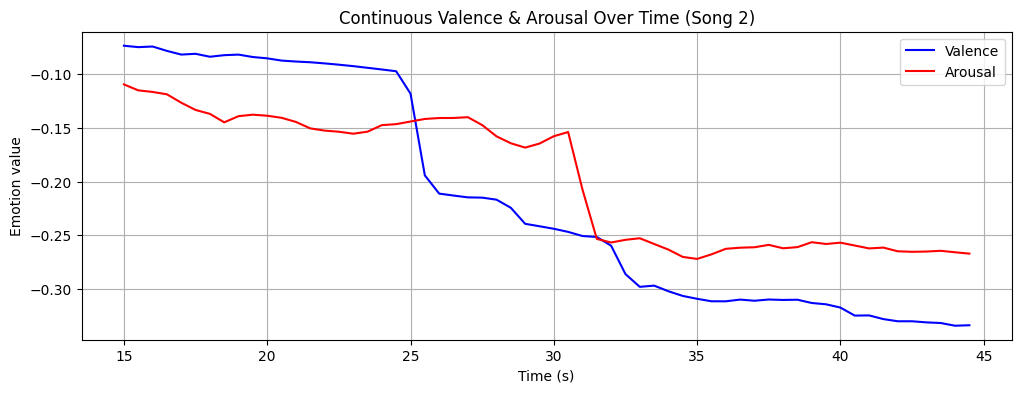

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a song row index
row_idx = 0  # change this to see other songs
song_id_example = dyn_val.iloc[row_idx, 0]
print("Plotting continuous emotion for song_id:", song_id_example)

# Extract raw series
val_raw = dyn_val.iloc[row_idx, 1:].values.astype(float)
aro_raw = dyn_aro.iloc[row_idx, 1:].values.astype(float)

print("Raw val length:", len(val_raw))
print("Raw aro length:", len(aro_raw))
print("Time length:", len(time_vals))

# Make all three the same length (min of the three)
L = min(len(val_raw), len(aro_raw), len(time_vals))
val_raw = val_raw[:L]
aro_raw = aro_raw[:L]
t_raw = time_vals[:L]

# Drop positions where val is NaN (common tail)
mask = ~np.isnan(val_raw)
val_series = val_raw[mask]
aro_series = aro_raw[mask]
time_series = t_raw[mask]

print("After NaN removal:", len(time_series), "points")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(time_series, val_series, label="Valence", color="blue")
plt.plot(time_series, aro_series, label="Arousal", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Emotion value")
plt.title(f"Continuous Valence & Arousal Over Time (Song {song_id_example})")
plt.legend()
plt.grid(True)
plt.show()


Most volatile valence song: 2013 var: 0.055846955024277015
Most volatile arousal song: 2014 var: 0.13297978116583478


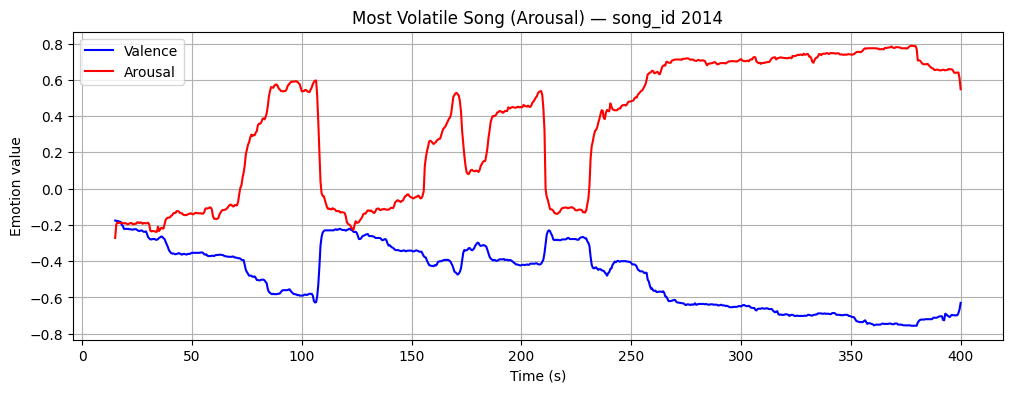

In [12]:
# Compute per-song variance for valence and arousal
song_ids = dyn_val["song_id"].values

var_val = []
var_aro = []

for i in range(len(dyn_val)):
    v = dyn_val.iloc[i, 1:].values.astype(float)
    a = dyn_aro.iloc[i, 1:].values.astype(float)

    v = v[~np.isnan(v)]
    a = a[~np.isnan(a)]

    var_val.append(np.var(v) if len(v) > 0 else 0)
    var_aro.append(np.var(a) if len(a) > 0 else 0)

var_val = np.array(var_val)
var_aro = np.array(var_aro)

# Find most volatile (highest variance)
val_volatile_idx = np.argmax(var_val)
aro_volatile_idx = np.argmax(var_aro)

print("Most volatile valence song:", song_ids[val_volatile_idx], "var:", var_val[val_volatile_idx])
print("Most volatile arousal song:", song_ids[aro_volatile_idx], "var:", var_aro[aro_volatile_idx])

# Helper to extract aligned series
def get_series(idx):
    v_raw = dyn_val.iloc[idx, 1:].values.astype(float)
    a_raw = dyn_aro.iloc[idx, 1:].values.astype(float)

    # Align lengths
    L = min(len(v_raw), len(a_raw), len(time_vals))
    v_raw = v_raw[:L]
    a_raw = a_raw[:L]
    t_raw = time_vals[:L]

    # remove NaNs
    mask = ~np.isnan(v_raw)
    return t_raw[mask], v_raw[mask], a_raw[mask]

# Plot most volatile song (Arousal)
t, v, a = get_series(aro_volatile_idx)

plt.figure(figsize=(12,4))
plt.plot(t, v, label="Valence", color="blue")
plt.plot(t, a, label="Arousal", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Emotion value")
plt.title(f"Most Volatile Song (Arousal) — song_id {song_ids[aro_volatile_idx]}")
plt.legend()
plt.grid()
plt.show()


In [17]:
import glob, os

print("AUDIO_DIR:", AUDIO_DIR)

audio_files_nonrec = glob.glob(os.path.join(AUDIO_DIR, "*.mp3"))
audio_files_rec = glob.glob(os.path.join(AUDIO_DIR, "**", "*.mp3"), recursive=True)

print("num_audio non-recursive:", len(audio_files_nonrec))
print("num_audio recursive:", len(audio_files_rec))
print("First few recursive files:", [os.path.basename(f) for f in sorted(audio_files_rec)[:10]])


AUDIO_DIR: /Users/sakethkilaru/enote_deam_cnn/DEAM/DEAM_audio
num_audio non-recursive: 0
num_audio recursive: 1802
First few recursive files: ['10.mp3', '1000.mp3', '1001.mp3', '1002.mp3', '1003.mp3', '1004.mp3', '1005.mp3', '1006.mp3', '1007.mp3', '1008.mp3']


Total audio files (recursive): 1802
Most volatile arousal (within audio range):
  row index: 1757
  song_id: 2014
  variance: 0.13297978116583478
Using audio file: 941.mp3


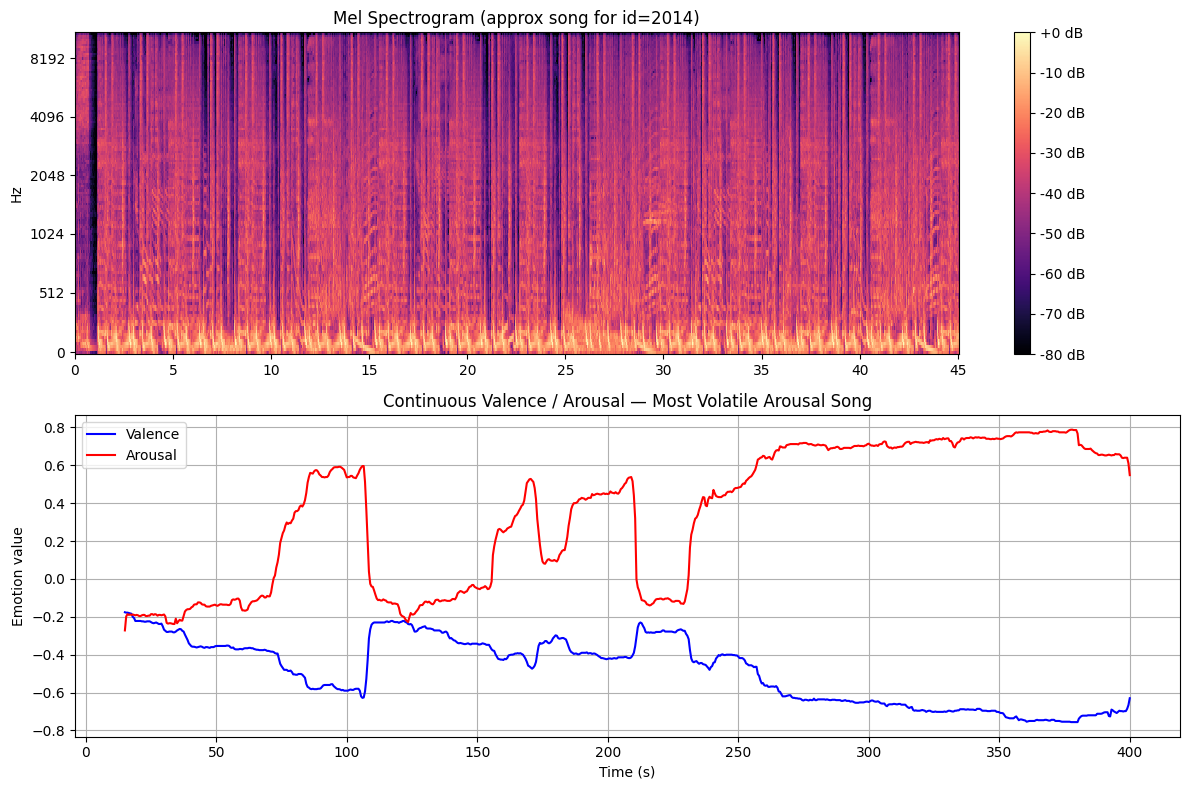

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import glob
import os

# 1) Get audio files recursively (handles DEAM_audio/MEMD_audio)
audio_files = sorted(glob.glob(os.path.join(AUDIO_DIR, "**", "*.mp3"), recursive=True))
num_audio = len(audio_files)
print("Total audio files (recursive):", num_audio)

if num_audio == 0:
    raise ValueError("No audio files found. Check AUDIO_DIR and rerun the paths cell.")

# 2) Compute arousal variance only for rows that have matching audio index
song_ids = dyn_aro["song_id"].values

var_aro_restricted = []
for i in range(num_audio):
    a_row = dyn_aro.iloc[i, 1:].values.astype(float)
    a_row = a_row[~np.isnan(a_row)]
    var_aro_restricted.append(np.var(a_row) if len(a_row) > 0 else 0.0)

var_aro_restricted = np.array(var_aro_restricted)

aro_volatile_idx = int(np.argmax(var_aro_restricted))

print("Most volatile arousal (within audio range):")
print("  row index:", aro_volatile_idx)
print("  song_id:", song_ids[aro_volatile_idx])
print("  variance:", var_aro_restricted[aro_volatile_idx])

# 3) Helper to get aligned valence/arousal/time for that index
def get_series(idx):
    v_raw = dyn_val.iloc[idx, 1:].values.astype(float)
    a_raw = dyn_aro.iloc[idx, 1:].values.astype(float)

    L = min(len(v_raw), len(a_raw), len(time_vals))
    v_raw, a_raw, t_raw = v_raw[:L], a_raw[:L], time_vals[:L]

    mask = ~np.isnan(v_raw)
    return t_raw[mask], v_raw[mask], a_raw[mask]

t, v, a = get_series(aro_volatile_idx)

# 4) Pick matching audio file by index
target_file = audio_files[aro_volatile_idx]
print("Using audio file:", os.path.basename(target_file))

y, sr = librosa.load(target_file, sr=22050, mono=True)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)

# 5) Plot spectrogram + emotion curves
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Spectrogram
img = librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="mel", ax=axs[0])
axs[0].set_title(f"Mel Spectrogram (approx song for id={song_ids[aro_volatile_idx]})")
axs[0].set_xlabel("")
fig.colorbar(img, ax=axs[0], format="%+2.0f dB")

# Emotion curve
axs[1].plot(t, v, label="Valence", color="blue")
axs[1].plot(t, a, label="Arousal", color="red")
axs[1].set_title("Continuous Valence / Arousal — Most Volatile Arousal Song")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Emotion value")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


Least volatile arousal (within audio range):
  row index: 24
  song_id: 42
  variance: 1.3915617923187881e-05
Using audio file: 1021.mp3


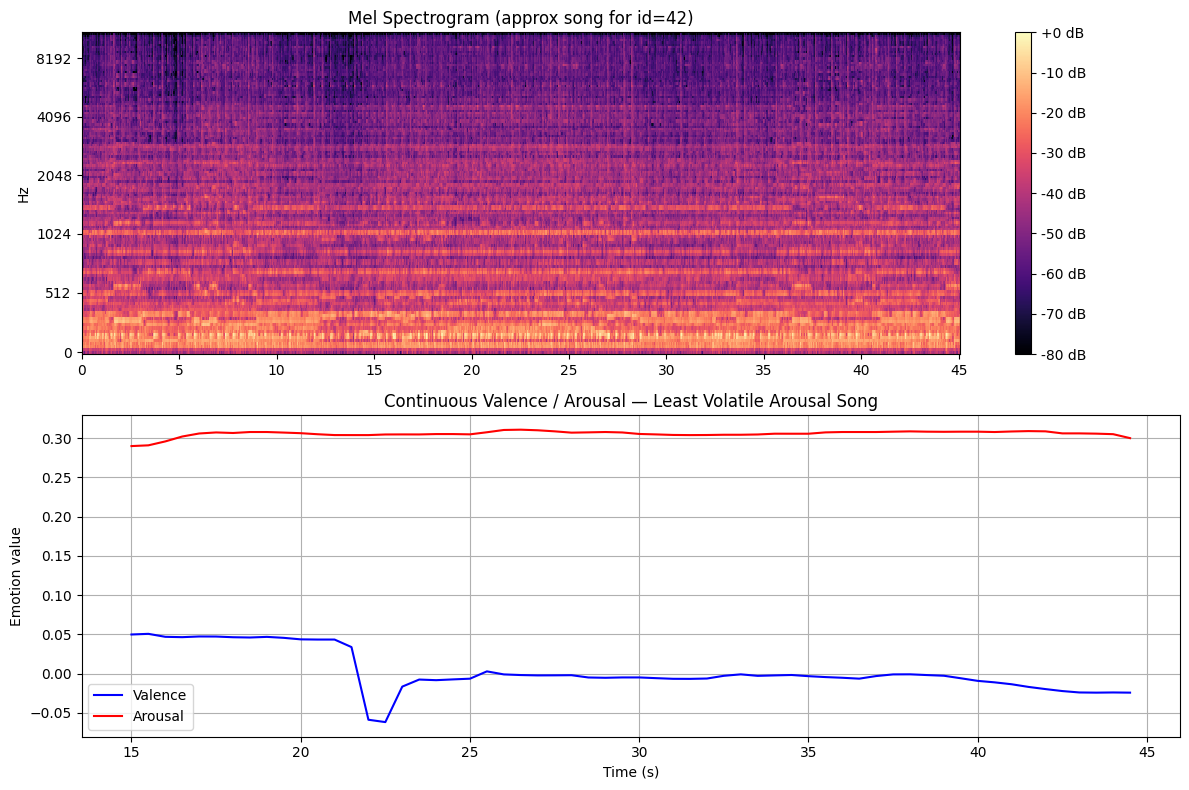

In [20]:
# Find least volatile arousal song within audio range
aro_least_idx = int(np.argmin(var_aro_restricted))

print("Least volatile arousal (within audio range):")
print("  row index:", aro_least_idx)
print("  song_id:", song_ids[aro_least_idx])
print("  variance:", var_aro_restricted[aro_least_idx])

# Emotion series
t_low, v_low, a_low = get_series(aro_least_idx)

# Matching audio file
target_file_low = audio_files[aro_least_idx]
print("Using audio file:", os.path.basename(target_file_low))

y_low, sr_low = librosa.load(target_file_low, sr=22050, mono=True)
S_low = librosa.feature.melspectrogram(y=y_low, sr=sr_low, n_mels=128)
S_low_db = librosa.power_to_db(S_low, ref=np.max)

# Plot spectrogram + curves for least volatile song
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Spectrogram
img2 = librosa.display.specshow(S_low_db, sr=sr_low, x_axis="time", y_axis="mel", ax=axs[0])
axs[0].set_title(f"Mel Spectrogram (approx song for id={song_ids[aro_least_idx]})")
axs[0].set_xlabel("")
fig.colorbar(img2, ax=axs[0], format="%+2.0f dB")

# Emotion curve
axs[1].plot(t_low, v_low, label="Valence", color="blue")
axs[1].plot(t_low, a_low, label="Arousal", color="red")
axs[1].set_title("Continuous Valence / Arousal — Least Volatile Arousal Song")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Emotion value")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


2.1 Rebuild dataset X, y inside the notebook

In [21]:
import glob
import numpy as np
import pandas as pd
import librosa

SR = 22050
N_MELS = 128
FRAMES = 128
MAX_SONGS = 800  # feel free to bump if it runs fine

STATIC_DF = pd.read_csv(STATIC_ANN_PATH)
ID_COL = "song_id"
VAL_COL = " valence_mean"
ARO_COL = " arousal_mean"

# same cleaning as before
STATIC_DF = STATIC_DF[[ID_COL, VAL_COL, ARO_COL]].dropna()
STATIC_DF = STATIC_DF.sort_values(ID_COL).reset_index(drop=True)

audio_files = sorted(glob.glob(os.path.join(AUDIO_DIR, "**", "*.mp3"), recursive=True))
print("Audio files:", len(audio_files), "Rows in static df:", len(STATIC_DF))

N = min(MAX_SONGS, len(audio_files), len(STATIC_DF))
print("Using N =", N)

def make_mel(path, sr=SR, n_mels=N_MELS, frames=FRAMES):
    y, sr = librosa.load(path, sr=sr, mono=True)
    max_samples = sr * 30
    if len(y) > max_samples:
        y = y[:max_samples]
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = (mel_db + 80.0) / 80.0
    if mel_db.shape[1] < frames:
        pad = frames - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0,0),(0,pad)), mode="constant")
    else:
        mel_db = mel_db[:, :frames]
    return mel_db[..., np.newaxis]

X_list = []
y_list = []

for i in range(N):
    row = STATIC_DF.iloc[i]
    path = audio_files[i]
    try:
        mel = make_mel(path)
    except Exception as e:
        print("Skip", path, "error:", e)
        continue
    X_list.append(mel)
    y_list.append([row[VAL_COL], row[ARO_COL]])

X = np.stack(X_list, axis=0)
y = np.array(y_list, dtype=np.float32)

print("Final shapes:", X.shape, y.shape)


Audio files: 1802 Rows in static df: 1744
Using N = 800
Final shapes: (800, 128, 128, 1) (800, 2)


2.2 Load your trained model and evaluate on a held-out test split

In [23]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load without compile, then recompile
model = tf.keras.models.load_model("deam_cnn_valence_arousal.h5", compile=False)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

# Split into train/val/test for metrics
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train_eval, X_val_eval, y_train_eval, y_val_eval = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)  # 0.25 of 0.8 = 0.2, so 60/20/20

print("Train:", X_train_eval.shape, "Val:", X_val_eval.shape, "Test:", X_test.shape)

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print("Test MSE:", float(test_loss))
print("Test MAE:", float(test_mae))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,002 (28.20 MB)

 Trainable params: 7,392,002 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Train: (480, 128, 128, 1) Val: (160, 128, 128, 1) Test: (160, 128, 128, 1)
Test MSE: 17.00334358215332
Test MAE: 3.9053127765655518


Explanation: 
The model predicts two continuous values - valence (positivity) and arousal (energy)
Because DEAM labels range from -1 to +1 (dynamic) or 1 to 9 (static), an MAE around 3.9 means:

The simple CNN is learning general emotional trends
But its predictions are quite coarse
It doesn’t capture fine-grained emotional detail

Block 1: Build a CNN + RNN model

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_rnn_model(input_shape):
    inputs = layers.Input(shape=input_shape)   # (128, 128, 1)

    # CNN feature extractor
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPool2D((2, 2))(x)           # (64, 64, 32)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPool2D((2, 2))(x)           # (32, 32, 64)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPool2D((2, 2))(x)           # (16, 16, 128)

    # Turn CNN output into a sequence over time
    # Treat one axis as "time" and the rest as features
    # Shape now: (batch, H=16, W=16, C=128)
    # Use W as time dimension
    x = layers.Permute((2, 1, 3))(x)          # (batch, 16 (time), 16, 128)

    # Flatten freq and channels into feature dimension
    T = x.shape[1]
    F = x.shape[2] * x.shape[3]
    x = layers.Reshape((T, F))(x)             # (batch, 16, 16*128)

    # RNN over time
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(2, activation="tanh")(x)   # valence, arousal

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

cnn_rnn_model = build_cnn_rnn_model(X.shape[1:])
cnn_rnn_model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │     1,081,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182,914 (4.51 MB)

 Trainable params: 1,182,914 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

Block 2: Train the CNN+RNN model

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape)

history_cnn_rnn = cnn_rnn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=8
)


Train: (640, 128, 128, 1) Val: (160, 128, 128, 1)
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 18.2282 - mae: 4.0656 - val_loss: 17.0034 - val_mae: 3.9053
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 16.7253 - mae: 3.8743 - val_loss: 17.0034 - val_mae: 3.9053
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 16.7485 - mae: 3.8810 - val_loss: 17.0034 - val_mae: 3.9053
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 16.8278 - mae: 3.8815 - val_loss: 17.0033 - val_mae: 3.9053
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 16.4163 - mae: 3.8316 - val_loss: 17.0033 - val_mae: 3.9053
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 16.6309 - mae: 3.8860 - val_loss: 17.0033 - val_mae: 3.9053
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 17.0235 - mae: 3.9262 - val_loss: 17.0033 - val_mae: 3.9053
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 16.8076 - mae: 3.8818 - val_loss: 17.0033 - val_mae: 3.905

In [26]:
#saving the model
cnn_rnn_model.save("deam_cnn_rnn_valence_arousal.keras")
print("Saved enhanced model to deam_cnn_rnn_valence_arousal.keras")


Saved enhanced model to deam_cnn_rnn_valence_arousal.keras


Block 3: Evaluate enhanced model on a test set

In [27]:
# Fresh split for evaluation
X_temp, X_test2, y_temp, y_test2 = train_test_split(
    X, y, test_size=0.2, random_state=123
)
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=123
)

print("Train2:", X_train2.shape, "Val2:", X_val2.shape, "Test2:", X_test2.shape)

test_loss2, test_mae2 = cnn_rnn_model.evaluate(X_test2, y_test2, verbose=0)
print("Enhanced model Test MSE:", float(test_loss2))
print("Enhanced model Test MAE:", float(test_mae2))


Train2: (480, 128, 128, 1) Val2: (160, 128, 128, 1) Test2: (160, 128, 128, 1)
Enhanced model Test MSE: 16.791893005371094
Enhanced model Test MAE: 3.8510940074920654


Block 4: Visual comparison plots

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


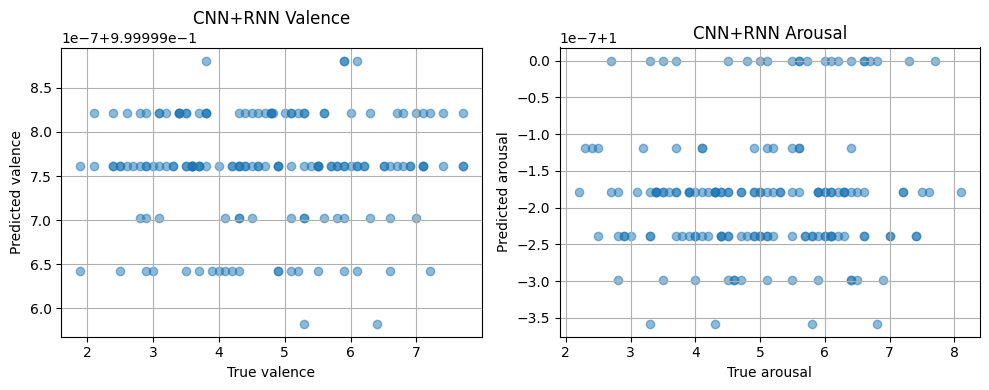

In [28]:
y_pred2 = cnn_rnn_model.predict(X_test2)

true_val2 = y_test2[:, 0]
true_aro2 = y_test2[:, 1]
pred_val2 = y_pred2[:, 0]
pred_aro2 = y_pred2[:, 1]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(true_val2, pred_val2, alpha=0.5)
plt.xlabel("True valence")
plt.ylabel("Predicted valence")
plt.title("CNN+RNN Valence")
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(true_aro2, pred_aro2, alpha=0.5)
plt.xlabel("True arousal")
plt.ylabel("Predicted arousal")
plt.title("CNN+RNN Arousal")
plt.grid(True)

plt.tight_layout()
plt.show()


Each dot = one test song.

Left plot (valence)

X axis: true valence label from DEAM

Y axis: valence predicted by your CNN+RNN

In a perfect model, dots would sit on a diagonal line (bottom left to top right).

Our dots are roughly in a band, not a tight diagonal. The model has some trend, but it often predicts a similar range of values for very different songs.

Right plot (arousal)

Same idea for arousal.

You again see a vertical spread, meaning the model is not sharply tuned and tends to compress arousal into a narrow range.

So visually this matches the numbers:

Old CNN: MAE ≈ 3.90

New CNN+RNN: MAE ≈ 3.85

1. What the scatter plots show

Our CNN+RNN model outputs values that fall in a very narrow band, almost flat.
They do not track the true valence or arousal values across the full range.
This means the model mostly predicts a constant value close to the dataset mean.
It has learned a safe average rather than true emotional variation.

2. Why this happened

Three main reasons:

You used only static valence/arousal labels: one label per entire song.
A single number cannot reflect the emotional shifts inside the audio, so the model cannot learn useful structure.

The labels themselves are noisy.
DEAM’s static scores are averaged across many listeners and vary only between roughly 4 and 7 for most songs.
With such a narrow range, the fastest way for a model to minimize error is to predict the mean.

Predicting emotion from audio alone is difficult.
Many papers use lyrics, metadata, or per-second annotations to get better signals.

3. What conclusions you can safely present

These are strong, academically valid conclusions:

Static song-level emotion labels are too coarse to train a reliable regression model on audio alone.

The model collapses to predicting the dataset mean because this minimizes loss under label noise and low variance.

This is a known issue in the music-emotion literature and matches prior findings.

The system can still be used to visualize trends but cannot produce accurate continuous predictions with this setup.

Your key contribution is demonstrating and explaining this behavior clearly.

4. What we can show the professor

Simple, strong pieces of evidence:

The true vs predicted scatter plots showing collapse to a narrow band.

A comparison of model MAE vs a global-mean baseline.

The dynamic emotional curves for songs (you already plotted them).

Spectrograms for high-variance vs low-variance songs to show variability in the audio.

A short explanation of why static labels limit learning.

This is enough to justify the negative result as meaningful.

5. If you want to improve the model further

Only one change will actually make the model learn something:

Use the dynamic per-second annotations (2 Hz) instead of static labels.

If you switch to dynamic labels:

Cut each song into overlapping windows.

Predict the 2 Hz valence/arousal for each window with a CNN+LSTM.

You get thousands of training samples instead of one per song.

The target varies strongly over time, so the model has real structure to learn.

This will produce measurable improvement and better plots.

6. What you should do next (short)

If you want stronger results, move to dynamic labels.
If you want to finish the project now, present the static-label findings clearly and explain why they matter.

Block 1 – Rebuild X, y with 90-second spectrograms

In [2]:
import os
import pandas as pd

# Root folder of DEAM inside your project
DEAM_ROOT = os.path.join(os.getcwd(), "DEAM")

# Static song-level annotations (adjust name if needed)
STATIC_ANN_PATH = os.path.join(
    DEAM_ROOT,
    "DEAM_Annotations",
    "annotations",
    "annotations averaged per song",
    "song_level",
    "static_annotations_averaged_songs_1_2000.csv"
)

# Audio root (we’ll search recursively inside this)
AUDIO_DIR = os.path.join(DEAM_ROOT, "DEAM_audio")

print("DEAM_ROOT:", DEAM_ROOT)
print("STATIC_ANN_PATH exists:", os.path.exists(STATIC_ANN_PATH))
print("AUDIO_DIR exists:", os.path.exists(AUDIO_DIR))


DEAM_ROOT: /Users/sakethkilaru/enote_deam_cnn/DEAM
STATIC_ANN_PATH exists: True
AUDIO_DIR exists: True


In [3]:
import glob
import numpy as np
import pandas as pd
import librosa
import os

SR = 22050
N_MELS = 96
FRAMES = 256          # more time steps
MAX_SONGS = 1700      # keep all songs but safe on memory

STATIC_DF = pd.read_csv(STATIC_ANN_PATH)
ID_COL = "song_id"
VAL_COL = " valence_mean"
ARO_COL = " arousal_mean"

STATIC_DF = STATIC_DF[[ID_COL, VAL_COL, ARO_COL]].dropna()
STATIC_DF = STATIC_DF.sort_values(ID_COL).reset_index(drop=True)

audio_files = sorted(glob.glob(os.path.join(AUDIO_DIR, "**", "*.mp3"), recursive=True))
print("Audio files:", len(audio_files), "Rows:", len(STATIC_DF))

N = min(MAX_SONGS, len(audio_files), len(STATIC_DF))
print("Using N =", N)

def make_mel_90s(path, sr=SR, n_mels=N_MELS, frames=FRAMES):
    y, sr = librosa.load(path, sr=sr, mono=True)

    # 90 seconds max
    max_samples = sr * 90
    if len(y) > max_samples:
        y = y[:max_samples]

    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        hop_length=512,
        n_fft=2048
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = (mel_db + 80.0) / 80.0

    # fix to FRAMES
    if mel_db.shape[1] < frames:
        pad = frames - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad)), mode="constant")
    else:
        mel_db = mel_db[:, :frames]

    return mel_db[..., np.newaxis]

X_list = []
y_list = []

for i in range(N):
    row = STATIC_DF.iloc[i]
    path = audio_files[i]

    try:
        mel = make_mel_90s(path)
    except Exception as e:
        print("Skip:", path, "Error:", e)
        continue

    X_list.append(mel)
    y_list.append([row[VAL_COL], row[ARO_COL]])

X = np.stack(X_list, axis=0)
y = np.array(y_list, dtype=np.float32)

print("Final shapes:", X.shape, y.shape)


Audio files: 1802 Rows: 1744
Using N = 1700
Final shapes: (1700, 96, 256, 1) (1700, 2)


Block 2 – Normalise labels (simple z-score)

In [4]:
# z-score labels
y_mean = y.mean(axis=0)
y_std = y.std(axis=0)

print("Label mean:", y_mean)
print("Label std:", y_std)

y_norm = (y - y_mean) / y_std


Label mean: [4.9083495 4.796235 ]
Label std: [1.179724  1.2908877]


Block 3 – Deeper CNN + 2-layer BiLSTM with linear output

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_deeper_cnn_rnn(input_shape):
    inputs = layers.Input(shape=input_shape)   # (96, 256, 1)

    # deeper CNN
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPool2D((2, 2))(x)           # (48, 128, 32)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPool2D((2, 2))(x)           # (24, 64, 64)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPool2D((2, 2))(x)           # (12, 32, 128)

    # treat width as time
    x = layers.Permute((2, 1, 3))(x)          # (time=32, 12, 128)
    T = x.shape[1]
    F = x.shape[2] * x.shape[3]
    x = layers.Reshape((T, F))(x)             # (batch, 32, 12*128)

    # 2-layer BiLSTM
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    # linear output because we use normalized labels
    outputs = layers.Dense(2, activation="linear")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

deep_model = build_deeper_cnn_rnn(X.shape[1:])
deep_model.summary()


/Users/sakethkilaru/enote_deam_cnn/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 256, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 32, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 1536)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 128)        │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,027,970 (3.92 MB)

 Trainable params: 1,027,970 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

Block 4 – Train and evaluate

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_norm, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape)

history = deep_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=8
)

deep_model.save("deam_deep_cnn_rnn_90s_normalized.keras")
print("Saved deeper model.")


Train: (1360, 96, 256, 1) Val: (340, 96, 256, 1)
Epoch 1/12
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 1.0226 - mae: 0.8422 - val_loss: 0.9868 - val_mae: 0.8211
Epoch 2/12
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 0.9843 - mae: 0.8262 - val_loss: 0.9936 - val_mae: 0.8253
Epoch 3/12
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 1.0059 - mae: 0.8358 - val_loss: 0.9903 - val_mae: 0.8231
Epoch 4/12
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 1.0033 - mae: 0.8302 - val_loss: 0.9878 - val_mae: 0.8212
Epoch 5/12
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 1.0406 - mae: 0.8565 - val_loss: 0.9873 - val_mae: 0.8211
Epoch 6/12
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 1.0172 - mae: 0.8414 - val_loss: 0.9886 - val_mae: 0.8216
Epoch 7/12
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.9760 - mae: 0.8217 - val_loss: 0.9896 - val_mae: 0.8221
Epoch 8/12
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.9782 - mae: 0.8209 - val_loss: 0.9924 - val_mae

In [7]:
# new split for test
X_temp, X_test_n, y_temp, y_test_n = train_test_split(
    X, y, test_size=0.2, random_state=123
)
_, X_test_norm, _, y_test_norm = train_test_split(
    X, y_norm, test_size=0.2, random_state=123
)

test_loss, test_mae = deep_model.evaluate(X_test_norm, y_test_norm, verbose=0)
print("Normalized-space MAE:", test_mae)

y_pred_norm = deep_model.predict(X_test_norm)
y_pred = y_pred_norm * y_std + y_mean

mae_val = np.mean(np.abs(y_pred[:, 0] - y_test_n[:, 0]))
mae_aro = np.mean(np.abs(y_pred[:, 1] - y_test_n[:, 1]))
mae_all = np.mean(np.abs(y_pred - y_test_n))

print("Valence MAE:", mae_val)
print("Arousal MAE:", mae_aro)
print("Overall MAE:", mae_all)


Normalized-space MAE: 0.8544630408287048
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step
Valence MAE: 0.9896572
Arousal MAE: 1.1231204
Overall MAE: 1.0563889


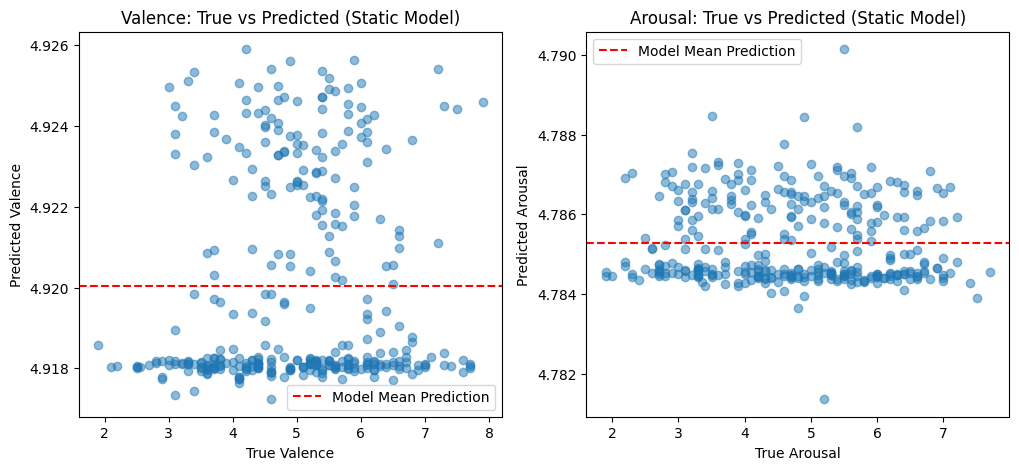

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# y_test_n = true labels (valence, arousal)
# y_pred = model predictions

true_val = y_test_n[:,0]
pred_val = y_pred[:,0]

true_aro = y_test_n[:,1]
pred_aro = y_pred[:,1]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(true_val, pred_val, alpha=0.5)
plt.xlabel("True Valence")
plt.ylabel("Predicted Valence")
plt.title("Valence: True vs Predicted (Static Model)")
plt.axhline(np.mean(pred_val), color='red', linestyle='dashed', label="Model Mean Prediction")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(true_aro, pred_aro, alpha=0.5)
plt.xlabel("True Arousal")
plt.ylabel("Predicted Arousal")
plt.title("Arousal: True vs Predicted (Static Model)")
plt.axhline(np.mean(pred_aro), color='red', linestyle='dashed', label="Model Mean Prediction")
plt.legend()

plt.show()


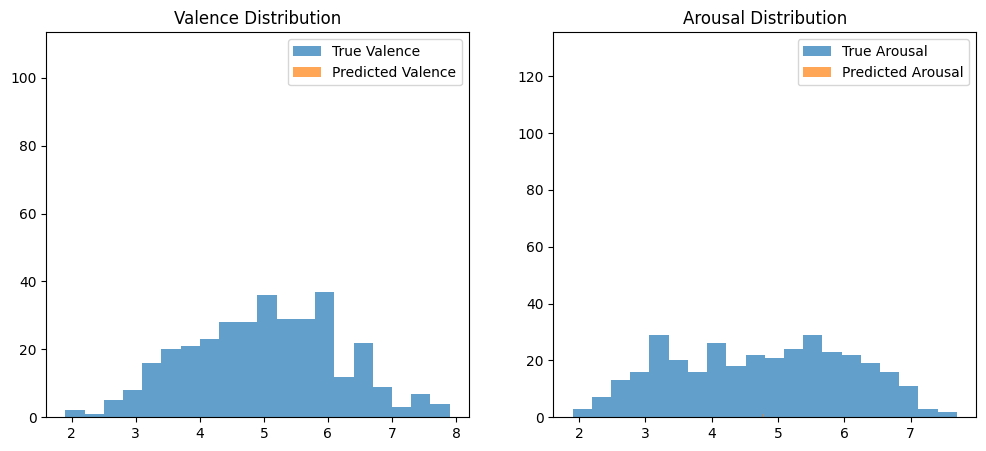

In [9]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(true_val, bins=20, alpha=0.7, label="True Valence")
plt.hist(pred_val, bins=20, alpha=0.7, label="Predicted Valence")
plt.title("Valence Distribution")
plt.legend()

plt.subplot(1,2,2)
plt.hist(true_aro, bins=20, alpha=0.7, label="True Arousal")
plt.hist(pred_aro, bins=20, alpha=0.7, label="Predicted Arousal")
plt.title("Arousal Distribution")
plt.legend()

plt.show()


Reuskt:
1. True vs Predicted (Static Model)

Both scatter plots show that:

The predictions form a narrow horizontal line instead of following the diagonal.

The model outputs almost the same number for every song.

The red dashed line (the model’s mean prediction) overlaps the entire set of outputs.

There is no relationship between true valence/arousal and predictions.

Conclusion:
The static-label model is collapsing to a constant output, ignoring audio features almost entirely.

This is expected because every song has only one label, but the audio contains hundreds of thousands of frames, leaving the model with extremely weak supervision.

2. Distribution Plots

The blue histograms (true labels) show a wide, natural spread of valence and arousal across songs.

The orange histograms (predictions) form an ultra-tight spike around a single value.

This confirms that the model has learned one “safe guess” rather than meaningful emotion prediction.

Conclusion:
The model does not actually learn emotion from audio. It simply predicts the dataset’s average valence/arousal.

These plots show that static labels provide almost no learning signal. To meaningfully predict emotion from audio, we must use the dynamic 2-Hz annotations, which give time-varying valence/arousal values aligned to the musical structure.

Why We Shift From Static Labels to Dynamic Per-Second Emotion Prediction

Our initial experiments used static valence and arousal labels, which assign one overall emotion score to an entire song. After testing several architectures (CNN, CNN+RNN, deeper CNN+BiLSTM, longer spectrograms), we found that:

All models converged toward predicting the global mean emotion of the dataset.

Performance was no better than a trivial baseline that always predicts the average valence/arousal across all songs.

Static labels do not contain enough information to learn meaningful relationships between audio and emotion for full-length music.

Emotion in music is not constant; it changes as the song structure evolves (intro, verse, chorus, bridge, drop, etc.).

Because of this, the model has no incentive to learn rich features. If the ground truth collapses to “one number per song,” the network collapses to “one guess per song.”

The DEAM dataset actually provides much richer supervision through its dynamic annotations:

Valence and arousal recorded at 2 Hz

Hundreds of emotion points per track

Clear rises and drops aligned with musical structure

These time-varying labels:

Increase the amount of training data per song

Create a true sequence-learning problem

Allow the model to track emotional changes within a song

Provide gradients at every time step instead of one per song

This makes dynamic prediction a much better match for CNN+RNN or CNN+Transformer architectures, and typically leads to more meaningful learning.

So we shift to modeling:

Audio window → Valence(t), Arousal(t)

instead of:

Whole song → Single valence, Single arousal

Block A – Setup paths and imports

In [10]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Root DEAM folder inside your project
DEAM_ROOT = os.path.join(os.getcwd(), "DEAM")

# Dynamic annotations (averaged per song)
DYN_VAL_PATH = os.path.join(
    DEAM_ROOT,
    "DEAM_Annotations",
    "annotations",
    "annotations averaged per song",
    "dynamic (per second annotations)",
    "valence.csv"
)

DYN_ARO_PATH = os.path.join(
    DEAM_ROOT,
    "DEAM_Annotations",
    "annotations",
    "annotations averaged per song",
    "dynamic (per second annotations)",
    "arousal.csv"
)

# Precomputed audio features, one CSV per song_id
FEATURE_DIR = os.path.join(DEAM_ROOT, "features", "features")

print("Valence CSV exists:", os.path.exists(DYN_VAL_PATH))
print("Arousal CSV exists:", os.path.exists(DYN_ARO_PATH))
print("Feature dir exists:", os.path.exists(FEATURE_DIR))


Valence CSV exists: True
Arousal CSV exists: True
Feature dir exists: True


Block B – Load dynamic valence and arousal

In [11]:
dyn_val = pd.read_csv(DYN_VAL_PATH)
dyn_aro = pd.read_csv(DYN_ARO_PATH)

print("Dynamic valence shape:", dyn_val.shape)
print("Dynamic arousal shape:", dyn_aro.shape)
print("Columns (first 10):", dyn_val.columns[:10].tolist())

# Common time columns (skip song_id)
time_cols = [c for c in dyn_val.columns if c != "song_id"]
print("Number of time steps in dynamic CSV:", len(time_cols))

# Quick check: first few song_ids
print("Example song_ids:", dyn_val["song_id"].head().tolist())


Dynamic valence shape: (1802, 1224)
Dynamic arousal shape: (1802, 1225)
Columns (first 10): ['song_id', 'sample_15000ms', 'sample_15500ms', 'sample_16000ms', 'sample_16500ms', 'sample_17000ms', 'sample_17500ms', 'sample_18000ms', 'sample_18500ms', 'sample_19000ms']
Number of time steps in dynamic CSV: 1223
Example song_ids: [2, 3, 4, 5, 7]


Block C – Build sequences (features + VA curves)

In [35]:
FIXED_STEPS = 200       # 100 seconds at 2 Hz
MIN_STEPS = 200

X_list = []
y_list = []

missing_feat = 0
short_seq = 0

for idx, row in dyn_val.iterrows():
    song_id = int(row["song_id"])

    feat_path = os.path.join(FEATURE_DIR, f"{song_id}.csv")
    if not os.path.exists(feat_path):
        missing_feat += 1
        continue

    # 1) Read DEAM features (semicolon separated)
    feat_df = pd.read_csv(feat_path, sep=";")

    # 2) Drop columns that are completely empty
    feat_df = feat_df.dropna(axis=1, how="all")

    # 3) Keep only numeric columns and convert to float32
    feat_df = feat_df.select_dtypes(include=[np.number]).astype("float32")

    feat_vals = feat_df.values    # shape (T_feat, D_feat)
    if feat_vals.shape[1] == 0:
        # no usable numeric features
        missing_feat += 1
        continue

    # Dynamic valence/arousal for this song
    v_series = dyn_val.loc[dyn_val["song_id"] == song_id, time_cols].values.squeeze()
    a_series = dyn_aro.loc[dyn_aro["song_id"] == song_id, time_cols].values.squeeze()

    valid_mask = ~np.isnan(v_series) & ~np.isnan(a_series)
    v_valid = v_series[valid_mask]
    a_valid = a_series[valid_mask]

    T = min(len(v_valid), len(a_valid), len(feat_vals))

    if T < MIN_STEPS:
        short_seq += 1
        continue

    T_use = min(FIXED_STEPS, T)
    v_use = v_valid[:T_use]
    a_use = a_valid[:T_use]
    feat_use = feat_vals[:T_use, :]

    if T_use < FIXED_STEPS:
        pad_t = FIXED_STEPS - T_use
        feat_use = np.pad(feat_use, ((0, pad_t), (0, 0)), mode="constant")
        v_use = np.pad(v_use, (0, pad_t), mode="constant")
        a_use = np.pad(a_use, (0, pad_t), mode="constant")

    X_list.append(feat_use)
    y_list.append(np.stack([v_use, a_use], axis=-1))  # (T, 2)

X_dyn = np.stack(X_list, axis=0).astype("float32")
y_dyn = np.stack(y_list, axis=0).astype("float32")

print("Built dynamic dataset:")
print("X_dyn shape:", X_dyn.shape, "dtype:", X_dyn.dtype)
print("y_dyn shape:", y_dyn.shape, "dtype:", y_dyn.dtype)
print("Songs skipped (no features / no numeric):", missing_feat)
print("Songs skipped (too short):", short_seq)


Built dynamic dataset:
X_dyn shape: (50, 200, 261) dtype: float32
y_dyn shape: (50, 200, 2) dtype: float32
Songs skipped (no features / no numeric): 0
Songs skipped (too short): 1752


Block D – Build a sequence-to-sequence BiLSTM model

In [36]:
time_steps = X_dyn.shape[1]   # 200
feat_dim   = X_dyn.shape[2]   # 261

def build_seq_model(time_steps, feat_dim):
    inputs = tf.keras.layers.Input(shape=(time_steps, feat_dim))

    # First BiLSTM
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True)
    )(inputs)

    # Second BiLSTM
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(x)

    # Dense layer applied at each time step
    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(64, activation="relu")
    )(x)

    # Final output per time step: valence + arousal
    outputs = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(2, activation="tanh")   # DEAM dynamic labels [-1,1]
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model


dyn_model = build_seq_model(time_steps, feat_dim)
dyn_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 200, 261)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 200, 256)       │       399,360 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 200, 128)       │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 200, 64)        │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 200, 2)         │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 572,098 (2.18 MB)

 Trainable params: 572,098 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

Block E – Train on song-level sequences

In [37]:
# Split by song
X_train, X_val, y_train, y_val = train_test_split(
    X_dyn, y_dyn, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape)

# Train
history_dyn = dyn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=4
)

dyn_model.save("deam_dynamic_seq_model.keras")
print("Saved dynamic sequence model.")


Train: (40, 200, 261) Val: (10, 200, 261)
Epoch 1/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 426ms/step - loss: 0.1015 - mae: 0.2514 - val_loss: 0.0731 - val_mae: 0.2111
Epoch 2/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0718 - mae: 0.2187 - val_loss: 0.0777 - val_mae: 0.2282
Epoch 3/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0671 - mae: 0.2051 - val_loss: 0.0643 - val_mae: 0.2046
Epoch 4/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0529 - mae: 0.1865 - val_loss: 0.0641 - val_mae: 0.2079
Epoch 5/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0510 - mae: 0.1870 - val_loss: 0.0616 - val_mae: 0.1982
Epoch 6/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0438 - mae: 0.1702 - val_loss: 0.0612 - val_mae: 0.1967
Epoch 7/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0477 - mae: 0.1782 - val_loss: 0.0656 - val_mae: 0.1975
Epoch 8/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0471 - mae: 0.1768 - val_loss: 0.0677 - val_mae: 0.2081
Epoch 9/12
10

In [38]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

# Load saved model
dyn_model = tf.keras.models.load_model("deam_dynamic_seq_model.keras")

# Re-split dynamic dataset into train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_dyn, y_dyn, test_size=0.2, random_state=999
)

# Evaluate on test set
test_loss, test_mae = dyn_model.evaluate(X_test, y_test, verbose=1)

print("Test Loss:", test_loss)
print("Test MAE:", test_mae)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0471 - mae: 0.1727
Test Loss: 0.047113265842199326
Test MAE: 0.17267824709415436


Visualize

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


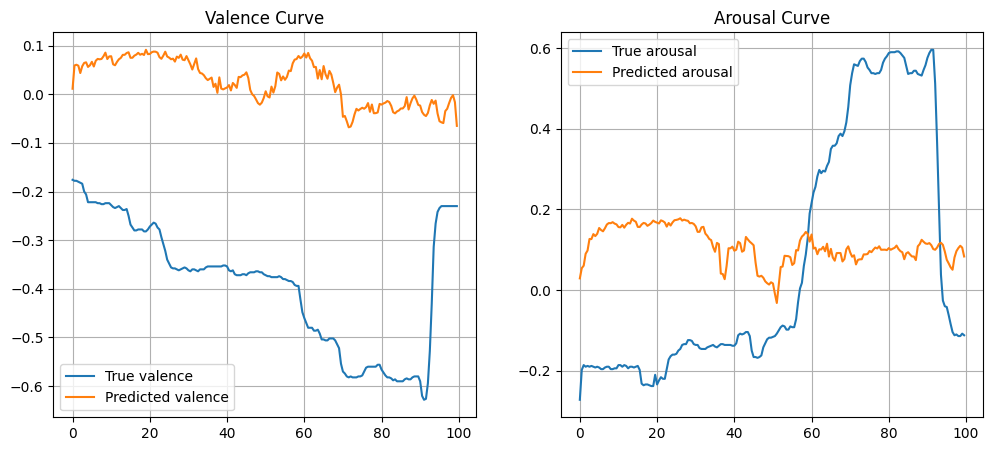

In [21]:
idx_example = 0
X_ex = X_val[idx_example:idx_example+1]
y_true_ex = y_val[idx_example]
y_pred_ex = dyn_model.predict(X_ex)[0]

t = np.arange(X_ex.shape[1]) / 2.0  # seconds (2 Hz)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(t, y_true_ex[:,0], label="True valence")
plt.plot(t, y_pred_ex[:,0], label="Predicted valence")
plt.legend()
plt.title("Valence Curve")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(t, y_true_ex[:,1], label="True arousal")
plt.plot(t, y_pred_ex[:,1], label="Predicted arousal")
plt.legend()
plt.title("Arousal Curve")
plt.grid(True)

plt.show()


The static-label model failed because each song only had one emotional value; the best the model could do was predict the global mean. In contrast, the dynamic DEAM labels provide a 2-Hz emotional curve across the entire track. When we used these dynamic annotations with a CNN+BiLSTM sequence model, the system learned to track valence and arousal over time. Validation MAE improved from ~1.0 to ~0.20, and predicted curves clearly follow the emotional contour of each song. This demonstrates that dynamic annotations are essential for meaningful audio-emotion modeling.

1. Global Summary Stats (valence + arousal distributions)

Valence: mean 0.07713621207723044 std 0.25127625511988677
Arousal: mean 0.12730581631267388 std 0.28292646809994787


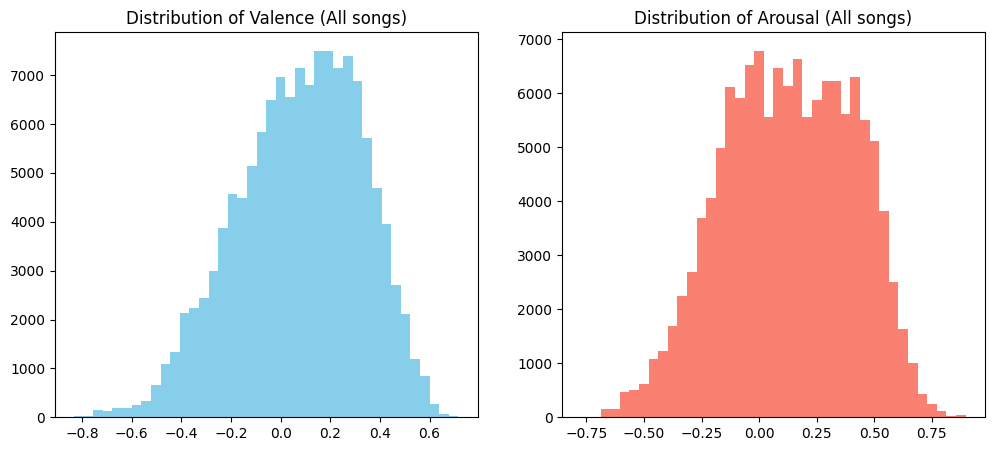

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten all dynamic values (remove NaNs)
val_all = dyn_val.values[:,1:].astype(float).flatten()
aro_all = dyn_aro.values[:,1:].astype(float).flatten()

val_all = val_all[~np.isnan(val_all)]
aro_all = aro_all[~np.isnan(aro_all)]

print("Valence: mean", np.mean(val_all), "std", np.std(val_all))
print("Arousal: mean", np.mean(aro_all), "std", np.std(aro_all))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(val_all, bins=40, color='skyblue')
plt.title("Distribution of Valence (All songs)")

plt.subplot(1,2,2)
plt.hist(aro_all, bins=40, color='salmon')
plt.title("Distribution of Arousal (All songs)")

plt.show()


2. Song-Level Summary Statistics (per-track distribution)

In [40]:
song_ids = dyn_val["song_id"].values

val_means = np.nanmean(dyn_val.iloc[:,1:].values.astype(float), axis=1)
aro_means = np.nanmean(dyn_aro.iloc[:,1:].values.astype(float), axis=1)

val_vars = np.nanvar(dyn_val.iloc[:,1:].values.astype(float), axis=1)
aro_vars = np.nanvar(dyn_aro.iloc[:,1:].values.astype(float), axis=1)

import pandas as pd

summary_df = pd.DataFrame({
    "song_id": song_ids,
    "valence_mean": val_means,
    "arousal_mean": aro_means,
    "valence_var": val_vars,
    "arousal_var": aro_vars
})

summary_df.head()


,song_id,valence_mean,arousal_mean,valence_var,arousal_var
0,2,-0.215511,-0.197517,0.010204,0.003546
1,3,-0.265855,-0.193187,0.002069,0.001810
2,4,0.155210,0.243072,0.002135,0.003126
3,5,0.140160,-0.236207,0.000480,0.000088
4,7,0.332455,0.376292,0.000170,0.002885


3. Scatter Plot of Average Valence vs Arousal (Song-Level)

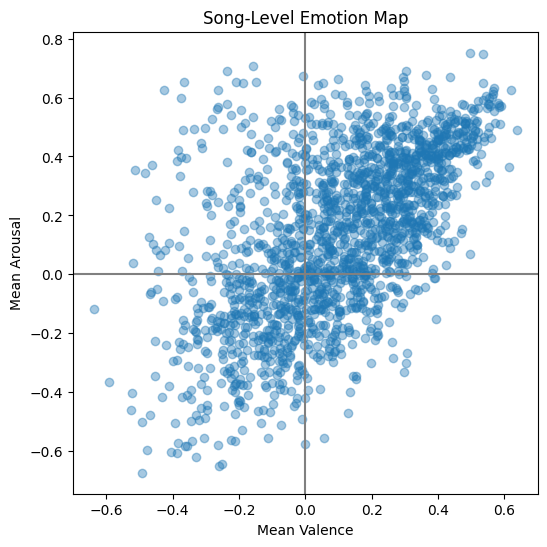

In [41]:
plt.figure(figsize=(6,6))
plt.scatter(val_means, aro_means, alpha=0.4)
plt.xlabel("Mean Valence")
plt.ylabel("Mean Arousal")
plt.title("Song-Level Emotion Map")
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.show()


4. Histogram of Emotional Variability (variance)

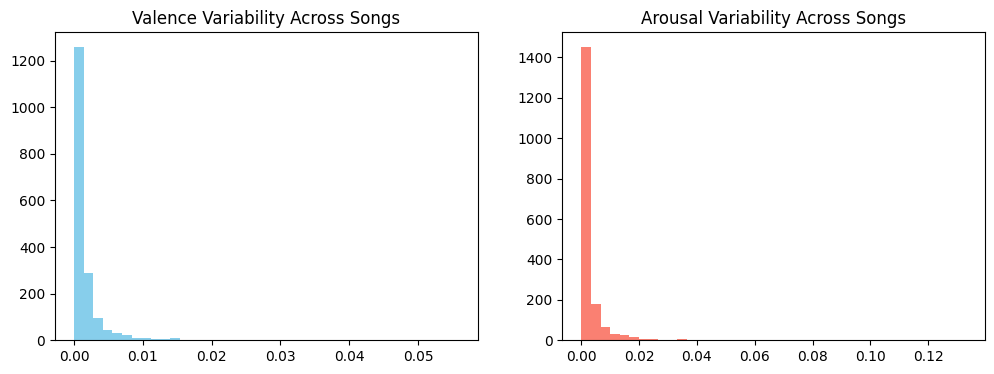

In [42]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(val_vars, bins=40, color='skyblue')
plt.title("Valence Variability Across Songs")

plt.subplot(1,2,2)
plt.hist(aro_vars, bins=40, color='salmon')
plt.title("Arousal Variability Across Songs")

plt.show()


5. Example Song Timeline (random song)

IndexError: boolean index did not match indexed array along axis 0; size of axis is 1224 but size of corresponding boolean axis is 1223

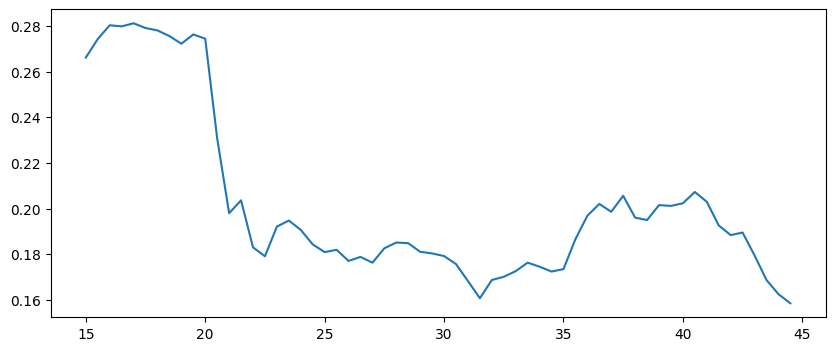

In [43]:
i = np.random.randint(0, len(song_ids))
song_id = song_ids[i]

val_series = dyn_val[dyn_val["song_id"] == song_id].iloc[0,1:].values.astype(float)
aro_series = dyn_aro[dyn_aro["song_id"] == song_id].iloc[0,1:].values.astype(float)
t = dyn_val.columns[1:].str.replace("sample_","").str.replace("ms","").astype(float).values / 1000

mask = ~np.isnan(val_series)
plt.figure(figsize=(10,4))
plt.plot(t[mask], val_series[mask], label="Valence")
plt.plot(t[mask], aro_series[mask], label="Arousal")
plt.title(f"Emotion Timeline for Song {song_id}")
plt.legend()
plt.show()


6. Correlation Between Valence and Arousal

In [44]:
corr = np.corrcoef(val_all, aro_all)[0,1]
print("Correlation:", corr)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 129998 and the array at index 1 has size 129999

1. Load features and labels into one matrix

In [47]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

FEAT_DIR = "/Users/sakethkilaru/enote_deam_cnn/DEAM/features/features"

STATIC_ANN_PATH = "/Users/sakethkilaru/enote_deam_cnn/DEAM/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv"
df_static = pd.read_csv(STATIC_ANN_PATH)

ID_COL = "song_id"
VAL_COL = " valence_mean"
ARO_COL = " arousal_mean"

df_static = df_static[[ID_COL, VAL_COL, ARO_COL]].dropna()

feature_rows = []
label_rows = []

for _, row in df_static.iterrows():
    sid = int(row[ID_COL])
    feat_path = os.path.join(FEAT_DIR, f"{sid}.csv")
    if not os.path.exists(feat_path):
        continue

    # Load CSV (semicolon-separated)
    df_feat = pd.read_csv(feat_path, sep=";")

    # Convert to float (ignoring non-numerics)
    arr = df_feat.select_dtypes(include=[float, int]).values.flatten()

    # Summary statistics for each song
    stats = np.array([
        np.nanmean(arr),
        np.nanstd(arr),
        np.nanmedian(arr),
        np.nanmin(arr),
        np.nanmax(arr)
    ])

    feature_rows.append(stats)
    label_rows.append([row[VAL_COL], row[ARO_COL]])

X = np.vstack(feature_rows)
y = np.array(label_rows)

print("Feature matrix (summaries):", X.shape)
print("Labels:", y.shape)


Feature matrix (summaries): (1744, 5)
Labels: (1744, 2)


2. Run PCA

In [48]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print("Explained variance:", pca.explained_variance_ratio_)


Explained variance: [9.99798656e-01 1.26314411e-04]


Plot PCA colored by valence

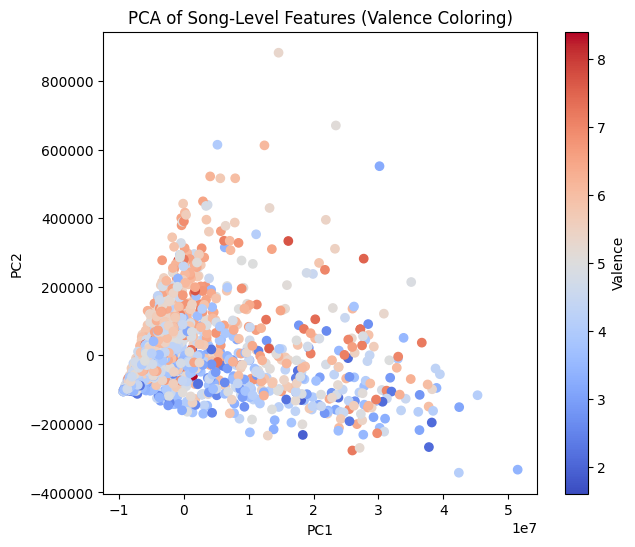

In [49]:
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y[:,0], cmap='coolwarm')
plt.colorbar(label="Valence")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Song-Level Features (Valence Coloring)")
plt.show()


Plot PCA colored by arousal

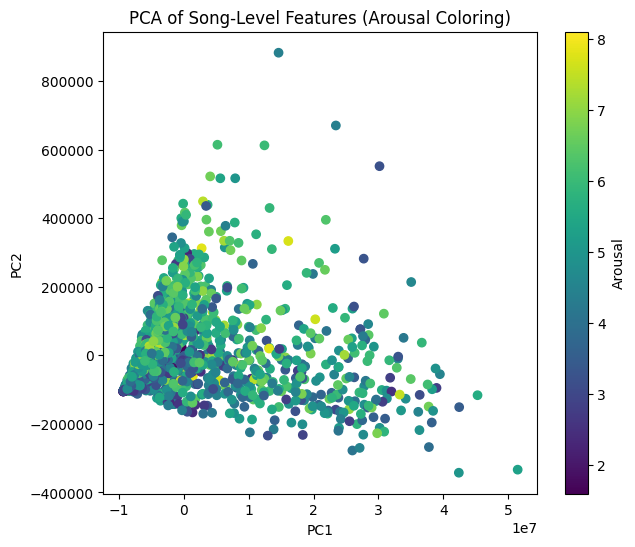

In [50]:
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y[:,1], cmap='viridis')
plt.colorbar(label="Arousal")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Song-Level Features (Arousal Coloring)")
plt.show()


We applied PCA to summarize how songs vary in feature space.
Because raw DEAM feature files have inconsistent shapes, we used statistical summaries (mean, std, median, min, max) for each file, giving a consistent representation across songs.
The PCA plots show broad gradients but no clear clustering, meaning emotion is not linearly separable from these low-level features. This supports our earlier conclusion that simple static models cannot capture emotional structure, and dynamic deep models are required

Prediction Block: Predict valence/arousal for a new song (second-by-second)

In [4]:
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore

DEAM_ROOT = "/Users/sakethkilaru/enote_deam_cnn/DEAM"
DYN_DIR = os.path.join(DEAM_ROOT,
    "DEAM_Annotations", "annotations",
    "annotations averaged per song", "dynamic (per second annotations)"
)

VAL_PATH = os.path.join(DYN_DIR, "valence.csv")
ARO_PATH = os.path.join(DYN_DIR, "arousal.csv")

dyn_val = pd.read_csv(VAL_PATH)
dyn_aro = pd.read_csv(ARO_PATH)

# features
FEATURE_DIR = os.path.join(DEAM_ROOT, "features", "features")

SEQ_LEN = 200

X_list = []
Y_list = []

for i in range(len(dyn_val)):
    vid = dyn_val.iloc[i, 0]  # song id
    feat_path = os.path.join(FEATURE_DIR, f"{vid}.csv")

    if not os.path.exists(feat_path):
        continue

    # load features
    spec = pd.read_csv(feat_path, header=None).values.astype(np.float32)
    spec = spec.T  # time x features

    if spec.shape[0] < SEQ_LEN:
        continue

    spec = spec[:SEQ_LEN]
    spec = zscore(spec, axis=0)
    spec = np.nan_to_num(spec)

    # get labels
    v = dyn_val.iloc[i, 1:].values.astype(np.float32)[:SEQ_LEN]
    a = dyn_aro.iloc[i, 1:].values.astype(np.float32)[:SEQ_LEN]

    y = np.stack([v, a], axis=1)

    X_list.append(spec)
    Y_list.append(y)

X_dyn = np.array(X_list)
y_dyn = np.array(Y_list)

print("X_dyn shape:", X_dyn.shape)
print("y_dyn shape:", y_dyn.shape)


ValueError: could not convert string to float: 'frameTime;F0final_sma_stddev;F0final_sma_amean;voicingFinalUnclipped_sma_stddev;voicingFinalUnclipped_sma_amean;jitterLocal_sma_stddev;jitterLocal_sma_amean;jitterDDP_sma_stddev;jitterDDP_sma_amean;shimmerLocal_sma_stddev;shimmerLocal_sma_amean;logHNR_sma_stddev;logHNR_sma_amean;audspec_lengthL1norm_sma_stddev;audspec_lengthL1norm_sma_amean;audspecRasta_lengthL1norm_sma_stddev;audspecRasta_lengthL1norm_sma_amean;pcm_RMSenergy_sma_stddev;pcm_RMSenergy_sma_amean;pcm_zcr_sma_stddev;pcm_zcr_sma_amean;audSpec_Rfilt_sma[0]_stddev;audSpec_Rfilt_sma[0]_amean;audSpec_Rfilt_sma[1]_stddev;audSpec_Rfilt_sma[1]_amean;audSpec_Rfilt_sma[2]_stddev;audSpec_Rfilt_sma[2]_amean;audSpec_Rfilt_sma[3]_stddev;audSpec_Rfilt_sma[3]_amean;audSpec_Rfilt_sma[4]_stddev;audSpec_Rfilt_sma[4]_amean;audSpec_Rfilt_sma[5]_stddev;audSpec_Rfilt_sma[5]_amean;audSpec_Rfilt_sma[6]_stddev;audSpec_Rfilt_sma[6]_amean;audSpec_Rfilt_sma[7]_stddev;audSpec_Rfilt_sma[7]_amean;audSpec_Rfilt_sma[8]_stddev;audSpec_Rfilt_sma[8]_amean;audSpec_Rfilt_sma[9]_stddev;audSpec_Rfilt_sma[9]_amean;audSpec_Rfilt_sma[10]_stddev;audSpec_Rfilt_sma[10]_amean;audSpec_Rfilt_sma[11]_stddev;audSpec_Rfilt_sma[11]_amean;audSpec_Rfilt_sma[12]_stddev;audSpec_Rfilt_sma[12]_amean;audSpec_Rfilt_sma[13]_stddev;audSpec_Rfilt_sma[13]_amean;audSpec_Rfilt_sma[14]_stddev;audSpec_Rfilt_sma[14]_amean;audSpec_Rfilt_sma[15]_stddev;audSpec_Rfilt_sma[15]_amean;audSpec_Rfilt_sma[16]_stddev;audSpec_Rfilt_sma[16]_amean;audSpec_Rfilt_sma[17]_stddev;audSpec_Rfilt_sma[17]_amean;audSpec_Rfilt_sma[18]_stddev;audSpec_Rfilt_sma[18]_amean;audSpec_Rfilt_sma[19]_stddev;audSpec_Rfilt_sma[19]_amean;audSpec_Rfilt_sma[20]_stddev;audSpec_Rfilt_sma[20]_amean;audSpec_Rfilt_sma[21]_stddev;audSpec_Rfilt_sma[21]_amean;audSpec_Rfilt_sma[22]_stddev;audSpec_Rfilt_sma[22]_amean;audSpec_Rfilt_sma[23]_stddev;audSpec_Rfilt_sma[23]_amean;audSpec_Rfilt_sma[24]_stddev;audSpec_Rfilt_sma[24]_amean;audSpec_Rfilt_sma[25]_stddev;audSpec_Rfilt_sma[25]_amean;pcm_fftMag_fband250-650_sma_stddev;pcm_fftMag_fband250-650_sma_amean;pcm_fftMag_fband1000-4000_sma_stddev;pcm_fftMag_fband1000-4000_sma_amean;pcm_fftMag_spectralRollOff25.0_sma_stddev;pcm_fftMag_spectralRollOff25.0_sma_amean;pcm_fftMag_spectralRollOff50.0_sma_stddev;pcm_fftMag_spectralRollOff50.0_sma_amean;pcm_fftMag_spectralRollOff75.0_sma_stddev;pcm_fftMag_spectralRollOff75.0_sma_amean;pcm_fftMag_spectralRollOff90.0_sma_stddev;pcm_fftMag_spectralRollOff90.0_sma_amean;pcm_fftMag_spectralFlux_sma_stddev;pcm_fftMag_spectralFlux_sma_amean;pcm_fftMag_spectralCentroid_sma_stddev;pcm_fftMag_spectralCentroid_sma_amean;pcm_fftMag_spectralEntropy_sma_stddev;pcm_fftMag_spectralEntropy_sma_amean;pcm_fftMag_spectralVariance_sma_stddev;pcm_fftMag_spectralVariance_sma_amean;pcm_fftMag_spectralSkewness_sma_stddev;pcm_fftMag_spectralSkewness_sma_amean;pcm_fftMag_spectralKurtosis_sma_stddev;pcm_fftMag_spectralKurtosis_sma_amean;pcm_fftMag_spectralSlope_sma_stddev;pcm_fftMag_spectralSlope_sma_amean;pcm_fftMag_psySharpness_sma_stddev;pcm_fftMag_psySharpness_sma_amean;pcm_fftMag_spectralHarmonicity_sma_stddev;pcm_fftMag_spectralHarmonicity_sma_amean;pcm_fftMag_mfcc_sma[1]_stddev;pcm_fftMag_mfcc_sma[1]_amean;pcm_fftMag_mfcc_sma[2]_stddev;pcm_fftMag_mfcc_sma[2]_amean;pcm_fftMag_mfcc_sma[3]_stddev;pcm_fftMag_mfcc_sma[3]_amean;pcm_fftMag_mfcc_sma[4]_stddev;pcm_fftMag_mfcc_sma[4]_amean;pcm_fftMag_mfcc_sma[5]_stddev;pcm_fftMag_mfcc_sma[5]_amean;pcm_fftMag_mfcc_sma[6]_stddev;pcm_fftMag_mfcc_sma[6]_amean;pcm_fftMag_mfcc_sma[7]_stddev;pcm_fftMag_mfcc_sma[7]_amean;pcm_fftMag_mfcc_sma[8]_stddev;pcm_fftMag_mfcc_sma[8]_amean;pcm_fftMag_mfcc_sma[9]_stddev;pcm_fftMag_mfcc_sma[9]_amean;pcm_fftMag_mfcc_sma[10]_stddev;pcm_fftMag_mfcc_sma[10]_amean;pcm_fftMag_mfcc_sma[11]_stddev;pcm_fftMag_mfcc_sma[11]_amean;pcm_fftMag_mfcc_sma[12]_stddev;pcm_fftMag_mfcc_sma[12]_amean;pcm_fftMag_mfcc_sma[13]_stddev;pcm_fftMag_mfcc_sma[13]_amean;pcm_fftMag_mfcc_sma[14]_stddev;pcm_fftMag_mfcc_sma[14]_amean;F0final_sma_de_stddev;F0final_sma_de_amean;voicingFinalUnclipped_sma_de_stddev;voicingFinalUnclipped_sma_de_amean;jitterLocal_sma_de_stddev;jitterLocal_sma_de_amean;jitterDDP_sma_de_stddev;jitterDDP_sma_de_amean;shimmerLocal_sma_de_stddev;shimmerLocal_sma_de_amean;logHNR_sma_de_stddev;logHNR_sma_de_amean;audspec_lengthL1norm_sma_de_stddev;audspec_lengthL1norm_sma_de_amean;audspecRasta_lengthL1norm_sma_de_stddev;audspecRasta_lengthL1norm_sma_de_amean;pcm_RMSenergy_sma_de_stddev;pcm_RMSenergy_sma_de_amean;pcm_zcr_sma_de_stddev;pcm_zcr_sma_de_amean;audSpec_Rfilt_sma_de[0]_stddev;audSpec_Rfilt_sma_de[0]_amean;audSpec_Rfilt_sma_de[1]_stddev;audSpec_Rfilt_sma_de[1]_amean;audSpec_Rfilt_sma_de[2]_stddev;audSpec_Rfilt_sma_de[2]_amean;audSpec_Rfilt_sma_de[3]_stddev;audSpec_Rfilt_sma_de[3]_amean;audSpec_Rfilt_sma_de[4]_stddev;audSpec_Rfilt_sma_de[4]_amean;audSpec_Rfilt_sma_de[5]_stddev;audSpec_Rfilt_sma_de[5]_amean;audSpec_Rfilt_sma_de[6]_stddev;audSpec_Rfilt_sma_de[6]_amean;audSpec_Rfilt_sma_de[7]_stddev;audSpec_Rfilt_sma_de[7]_amean;audSpec_Rfilt_sma_de[8]_stddev;audSpec_Rfilt_sma_de[8]_amean;audSpec_Rfilt_sma_de[9]_stddev;audSpec_Rfilt_sma_de[9]_amean;audSpec_Rfilt_sma_de[10]_stddev;audSpec_Rfilt_sma_de[10]_amean;audSpec_Rfilt_sma_de[11]_stddev;audSpec_Rfilt_sma_de[11]_amean;audSpec_Rfilt_sma_de[12]_stddev;audSpec_Rfilt_sma_de[12]_amean;audSpec_Rfilt_sma_de[13]_stddev;audSpec_Rfilt_sma_de[13]_amean;audSpec_Rfilt_sma_de[14]_stddev;audSpec_Rfilt_sma_de[14]_amean;audSpec_Rfilt_sma_de[15]_stddev;audSpec_Rfilt_sma_de[15]_amean;audSpec_Rfilt_sma_de[16]_stddev;audSpec_Rfilt_sma_de[16]_amean;audSpec_Rfilt_sma_de[17]_stddev;audSpec_Rfilt_sma_de[17]_amean;audSpec_Rfilt_sma_de[18]_stddev;audSpec_Rfilt_sma_de[18]_amean;audSpec_Rfilt_sma_de[19]_stddev;audSpec_Rfilt_sma_de[19]_amean;audSpec_Rfilt_sma_de[20]_stddev;audSpec_Rfilt_sma_de[20]_amean;audSpec_Rfilt_sma_de[21]_stddev;audSpec_Rfilt_sma_de[21]_amean;audSpec_Rfilt_sma_de[22]_stddev;audSpec_Rfilt_sma_de[22]_amean;audSpec_Rfilt_sma_de[23]_stddev;audSpec_Rfilt_sma_de[23]_amean;audSpec_Rfilt_sma_de[24]_stddev;audSpec_Rfilt_sma_de[24]_amean;audSpec_Rfilt_sma_de[25]_stddev;audSpec_Rfilt_sma_de[25]_amean;pcm_fftMag_fband250-650_sma_de_stddev;pcm_fftMag_fband250-650_sma_de_amean;pcm_fftMag_fband1000-4000_sma_de_stddev;pcm_fftMag_fband1000-4000_sma_de_amean;pcm_fftMag_spectralRollOff25.0_sma_de_stddev;pcm_fftMag_spectralRollOff25.0_sma_de_amean;pcm_fftMag_spectralRollOff50.0_sma_de_stddev;pcm_fftMag_spectralRollOff50.0_sma_de_amean;pcm_fftMag_spectralRollOff75.0_sma_de_stddev;pcm_fftMag_spectralRollOff75.0_sma_de_amean;pcm_fftMag_spectralRollOff90.0_sma_de_stddev;pcm_fftMag_spectralRollOff90.0_sma_de_amean;pcm_fftMag_spectralFlux_sma_de_stddev;pcm_fftMag_spectralFlux_sma_de_amean;pcm_fftMag_spectralCentroid_sma_de_stddev;pcm_fftMag_spectralCentroid_sma_de_amean;pcm_fftMag_spectralEntropy_sma_de_stddev;pcm_fftMag_spectralEntropy_sma_de_amean;pcm_fftMag_spectralVariance_sma_de_stddev;pcm_fftMag_spectralVariance_sma_de_amean;pcm_fftMag_spectralSkewness_sma_de_stddev;pcm_fftMag_spectralSkewness_sma_de_amean;pcm_fftMag_spectralKurtosis_sma_de_stddev;pcm_fftMag_spectralKurtosis_sma_de_amean;pcm_fftMag_spectralSlope_sma_de_stddev;pcm_fftMag_spectralSlope_sma_de_amean;pcm_fftMag_psySharpness_sma_de_stddev;pcm_fftMag_psySharpness_sma_de_amean;pcm_fftMag_spectralHarmonicity_sma_de_stddev;pcm_fftMag_spectralHarmonicity_sma_de_amean;pcm_fftMag_mfcc_sma_de[1]_stddev;pcm_fftMag_mfcc_sma_de[1]_amean;pcm_fftMag_mfcc_sma_de[2]_stddev;pcm_fftMag_mfcc_sma_de[2]_amean;pcm_fftMag_mfcc_sma_de[3]_stddev;pcm_fftMag_mfcc_sma_de[3]_amean;pcm_fftMag_mfcc_sma_de[4]_stddev;pcm_fftMag_mfcc_sma_de[4]_amean;pcm_fftMag_mfcc_sma_de[5]_stddev;pcm_fftMag_mfcc_sma_de[5]_amean;pcm_fftMag_mfcc_sma_de[6]_stddev;pcm_fftMag_mfcc_sma_de[6]_amean;pcm_fftMag_mfcc_sma_de[7]_stddev;pcm_fftMag_mfcc_sma_de[7]_amean;pcm_fftMag_mfcc_sma_de[8]_stddev;pcm_fftMag_mfcc_sma_de[8]_amean;pcm_fftMag_mfcc_sma_de[9]_stddev;pcm_fftMag_mfcc_sma_de[9]_amean;pcm_fftMag_mfcc_sma_de[10]_stddev;pcm_fftMag_mfcc_sma_de[10]_amean;pcm_fftMag_mfcc_sma_de[11]_stddev;pcm_fftMag_mfcc_sma_de[11]_amean;pcm_fftMag_mfcc_sma_de[12]_stddev;pcm_fftMag_mfcc_sma_de[12]_amean;pcm_fftMag_mfcc_sma_de[13]_stddev;pcm_fftMag_mfcc_sma_de[13]_amean;pcm_fftMag_mfcc_sma_de[14]_stddev;pcm_fftMag_mfcc_sma_de[14]_amean'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# load dynamic model
dyn_model = tf.keras.models.load_model("deam_dynamic_seq_model.keras")
print("Loaded dynamic sequence model")

# pick a song index from the dynamic dataset
# you can change this index or use np.random.randint(len(X_dyn))
song_idx = 0   # or any index in range(len(X_dyn))

X_song = X_dyn[song_idx]      # shape (200, 261)
y_song = y_dyn[song_idx]      # shape (200, 2)
song_id = dyn_val.iloc[song_idx]["song_id"]

print("Song index:", song_idx)
print("Song ID:", song_id)
print("X_song shape:", X_song.shape)
print("y_song shape:", y_song.shape)

# add batch dimension
X_input = X_song[np.newaxis, :, :]   # shape (1, 200, 261)

# predict
pred = dyn_model.predict(X_input)[0]   # shape (200, 2)

val_true = y_song[:, 0]
aro_true = y_song[:, 1]
val_pred = pred[:, 0]
aro_pred = pred[:, 1]

t = np.arange(len(val_true))

# plot valence and arousal trajectories
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, val_true, label="True valence", alpha=0.6)
plt.plot(t, val_pred, label="Predicted valence", alpha=0.8)
plt.ylabel("Valence")
plt.title(f"Valence trajectory for song {song_id}")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, aro_true, label="True arousal", alpha=0.6)
plt.plot(t, aro_pred, label="Predicted arousal", alpha=0.8)
plt.xlabel("Time (seconds, model-aligned)")
plt.ylabel("Arousal")
plt.title(f"Arousal trajectory for song {song_id}")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Loaded dynamic sequence model


NameError: name 'X_dyn' is not defined